In [1]:
import numpy as np
import pandas as pd
import json
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201


2025-06-14 08:24:34.565724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749889474.822339      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749889474.898274      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# What is Image Captioning?
Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
This task lies at the intersection of computer vision and natural language processing

 
**How it Works**
It typically involves two main components:

1.*Feature Extraction* (Vision part)

A Convolutional Neural Network (CNN) (e.g., VGG16) processes the image and extracts its features (e.g., objects, colors, layout).

2.*Sequence Generation* (Language part)

A Recurrent Neural Network (RNN) or LSTM takes these features and generates a sentence word-by-word — like:
startseq → a man riding a horse → endseq

📌 *Example*
Image: 🐴 A man riding a horse on a beach
Caption: "a man is riding a horse on the beach"

In [2]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# About the dataset

**Basic Info**

The COCO dataset (Common Objects in Context) is a large-scale dataset of images and annotations for object detection, segmentation, and captioning. It is one of the most popular datasets in computer vision research, and has been used to train and evaluate many state-of-the-art models.

The COCO dataset is a valuable resource for researchers working on object detection, segmentation, and captioning. It is a large, challenging dataset that provides a wide variety of images and annotations. The COCO dataset is also well-organized and easy to use.

*2014 Data*
The 2014 Data is used as Training and Validation data for the task of Image captioning

*2017 Data*
The 2017 Data is used as Testing data

In [3]:
import os

folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'

file_list = os.listdir(folder_path)
num_files = len(file_list)

print(f"There are {num_files} files in the directory {folder_path}")

There are 82783 files in the directory /kaggle/input/coco-image-caption/train2014/train2014


In [4]:
image_folder_path = '/kaggle/input/coco-image-caption/train2014/train2014'
caption_folder_path = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations'

In [5]:
captions_data = []
caption_file_path = os.path.join(caption_folder_path, 'captions_train2014.json')

with open(caption_file_path, 'r') as file:
    captions_data = json.load(file)

In [6]:
file_names = []
image_ids = []
captions = []

annotations = captions_data['annotations']
images=captions_data['images']

# Create a dictionary to map image_id to file_name
image_id_to_filename = {image['id']: image['file_name'] for image in images}

# Initialize empty lists to store the data
image_ids = []
captions = []
file_names = []

# Loop through the list of annotations
for annotation in annotations:
    image_id = annotation['image_id']
    if image_id in image_id_to_filename:
        file_name = image_id_to_filename[image_id]
        image_ids.append(image_id)
        captions.append(annotation['caption'])
        file_names.append(file_name)

# Create a pandas DataFrame using the extracted data
data = {
    'image_id': image_ids,
     'image': file_names,
    'caption': captions

}

data = pd.DataFrame(data)

In [7]:
data

,image_id,image,caption
0,318556,COCO_train2014_000000318556.jpg,A very clean and well decorated empty bathroom
1,116100,COCO_train2014_000000116100.jpg,A panoramic view of a kitchen and all of its a...
2,318556,COCO_train2014_000000318556.jpg,A blue and white bathroom with butterfly theme...
3,116100,COCO_train2014_000000116100.jpg,A panoramic photo of a kitchen and dining room
4,379340,COCO_train2014_000000379340.jpg,A graffiti-ed stop sign across the street from...
...,...,...,...
414108,133071,COCO_train2014_000000133071.jpg,a slice of bread is covered with a sour cream ...
414109,410182,COCO_train2014_000000410182.jpg,A long plate hold some fries with some sliders...
414110,180285,COCO_train2014_000000180285.jpg,Two women sit and pose with stuffed animals.
414111,133071,COCO_train2014_000000133071.jpg,White Plate with a lot of guacamole and an ext...


In [8]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from textwrap import wrap

# 1. Read image with full filename
def read_coco_image(filename, img_size=224, base_path='/kaggle/input/coco-image-caption/train2014/train2014'):
    path = os.path.join(base_path, filename)
    if not os.path.exists(path):
        print(f"[Missing File] {path}")
        return None
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    return img

# 2. Display a batch of images with captions
def display_images(df, img_size=224, base_path='/kaggle/input/coco-image-caption/train2014/train2014'):
    df = df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    shown = 0
    for i in range(len(df)):
        image = read_coco_image(df.image[i], img_size=img_size, base_path=base_path)
        if image is None:
            continue
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        plt.imshow(image)
        plt.title("\n".join(wrap(df.caption[i], 20)))
        plt.axis("off")
        shown += 1
        if shown == 15:
            break
    plt.show()


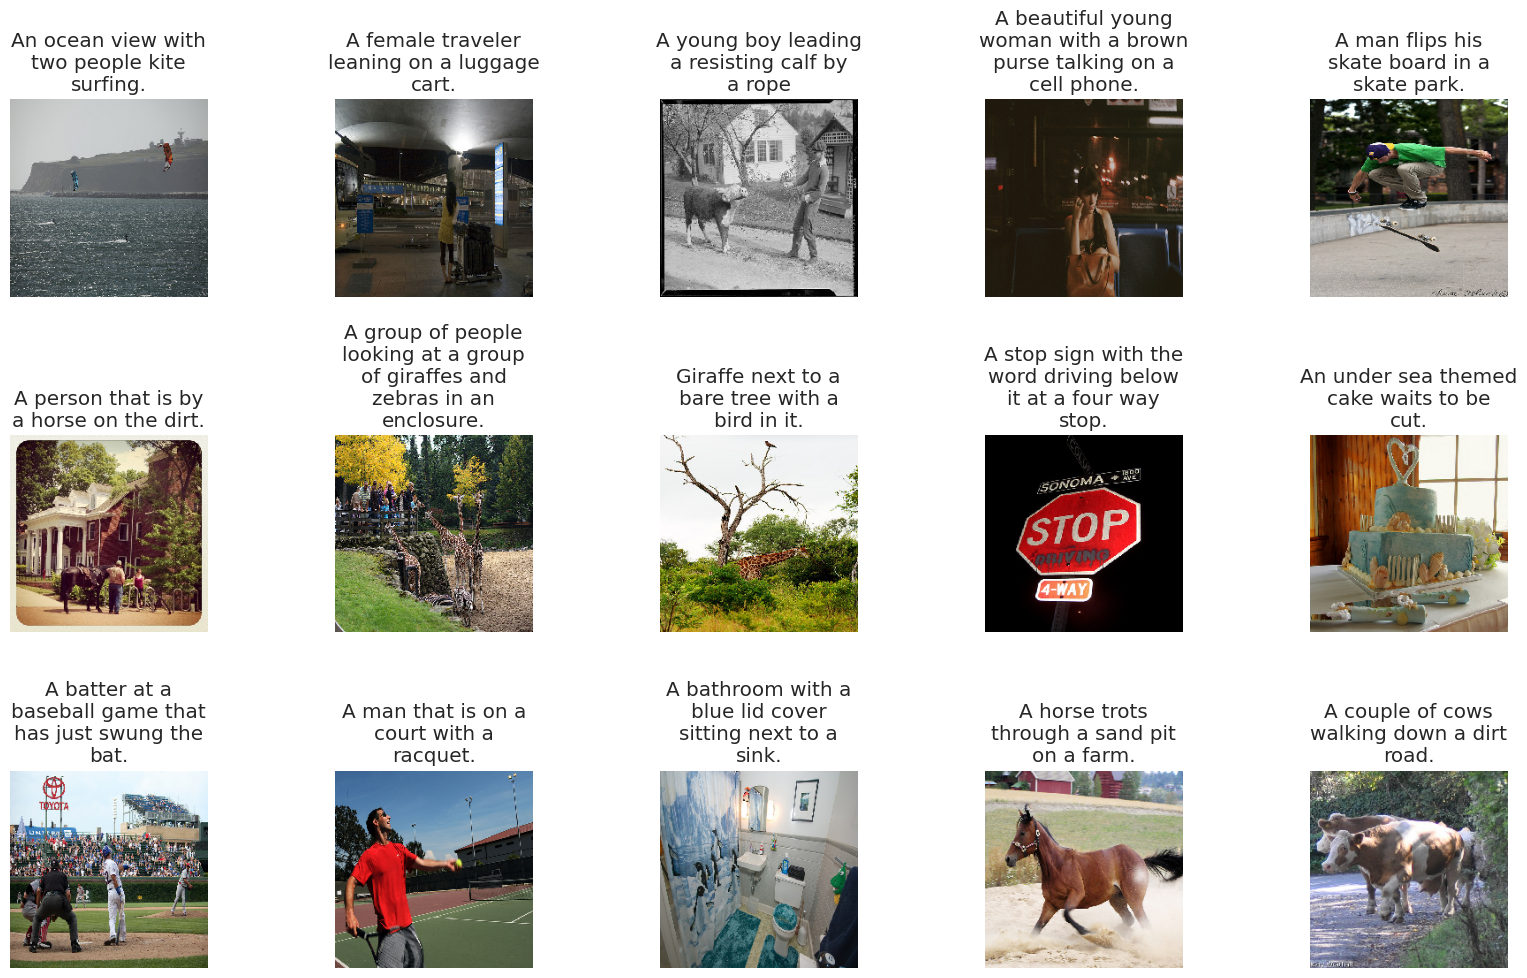

In [9]:
display_images(data.sample(15))


# Text preprocessing 
Text preprocessing is a crucial step in Natural Language Processing (NLP) that involves cleaning and transforming raw text data into a suitable format for analysis or modeling. This process helps improve data quality, enhance model performance, and reduce computational complexity.

There are various techniques available for text preprocessing but the one we will be using are:


1.*Lowercasing* – Makes all captions lowercase to ensure consistency.
Example: "A Cat Sitting On The Mat" → "a cat sitting on the mat"

2.*Punctuation Removal*  – Removes symbols like .,!?" etc., if they do not add semantic value.

3.*Token Insertion* – Adding special tokens:

"startseq" at the beginning

"endseq" at the end
These are critical for training sequence models.

Example: "a cat on a mat" → "startseq a cat on a mat endseq"

4.*Tokenization* – Splitting sentences into words (or subwords).
Used by Tokenizer.texts_to_sequences().

5.*Vocabulary Creation* – Build a word-index dictionary (word_index, index_word) from all training captions.

6.*Padding* – Ensures all input sequences are the same length (using pad_sequences with maxlen).

In [10]:
import re 

def text_preprocessing(data):
    # Convert to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())

    # Remove non-alphabetical characters
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"[^a-z\s]", "", x))

    # Replace multiple spaces with single space
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x).strip())

    # Add start and end tokens
    data['caption'] = data['caption'].apply(lambda x: f"startseq {x} endseq")

    return data


In [11]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
print(captions[:10])


['startseq a very clean and well decorated empty bathroom endseq', 'startseq a panoramic view of a kitchen and all of its appliances endseq', 'startseq a blue and white bathroom with butterfly themed wall tiles endseq', 'startseq a panoramic photo of a kitchen and dining room endseq', 'startseq a graffitied stop sign across the street from a red car endseq', 'startseq a vandalized stop sign and a red beetle on the road endseq', 'startseq a bathroom with a border of butterflies and blue paint on the walls above it endseq', 'startseq an angled view of a beautifully decorated bathroom endseq', 'startseq the two people are walking down the beach endseq', 'startseq a sink and a toilet inside a small bathroom endseq']


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(data['caption'].tolist())

vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in data['caption'])

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85 * nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(val_images)].reset_index(drop=True)


In [13]:
sample_caption = train['caption'][1]
sequence = tokenizer.texts_to_sequences([sample_caption])[0]

print("Original Caption:", sample_caption)
print("Tokenized Sequence:", sequence)


Original Caption: startseq a panoramic view of a kitchen and all of its appliances endseq
Tokenized Sequence: [3, 2, 3974, 172, 6, 2, 62, 10, 317, 6, 114, 611, 4]


# Feature extraction 
Feature extraction is a crucial step in machine learning that involves transforming raw data into a set of numerical features that can be used for modeling. This process helps in reducing the number of resources required for processing while retaining significant information.

*Convolutional neural network*

Convolutional Neural networks are specialized deep neural networks which can process the data that has input shape like a 2D matrix. Images are easily represented as a 2D matrix and CNN is very useful in working with images.

CNN is basically used for image classifications and identifying if an image is a bird, a plane or Superman, etc.


It scans images from left to right and top to bottom to pull out important features from the image and combines the feature to classify images. It can handle the images that have been translated, rotated, scaled and changes in perspective.


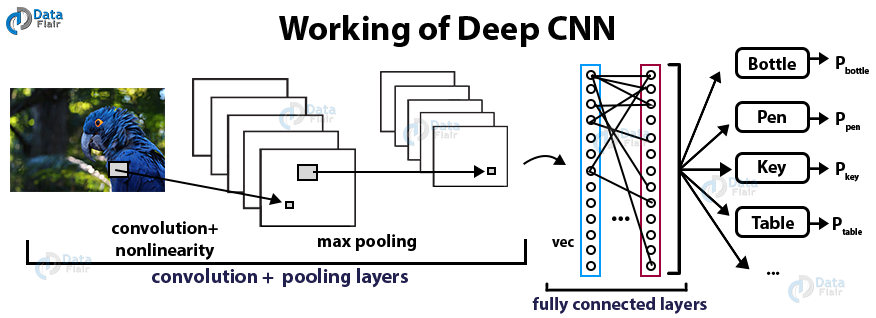
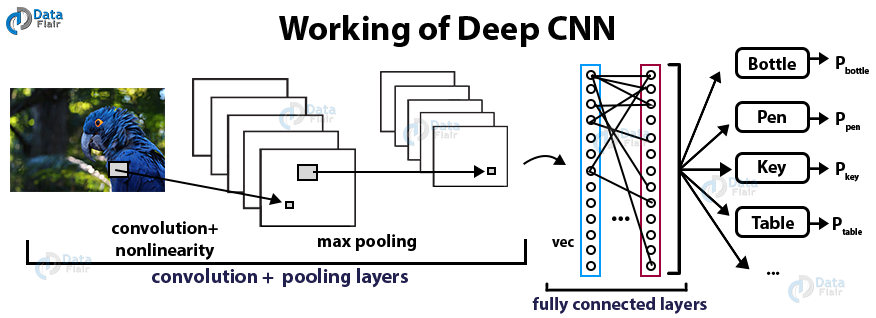
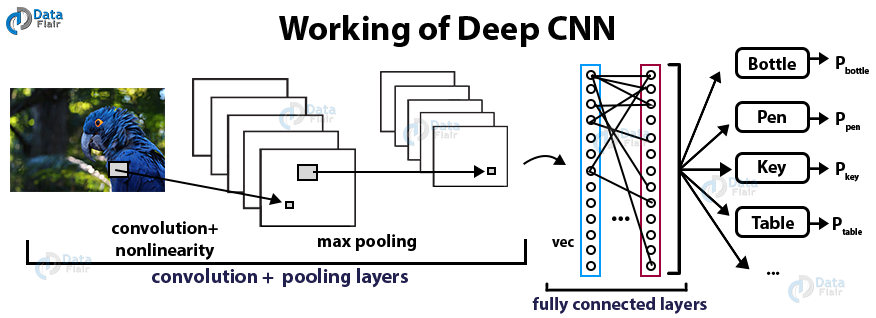
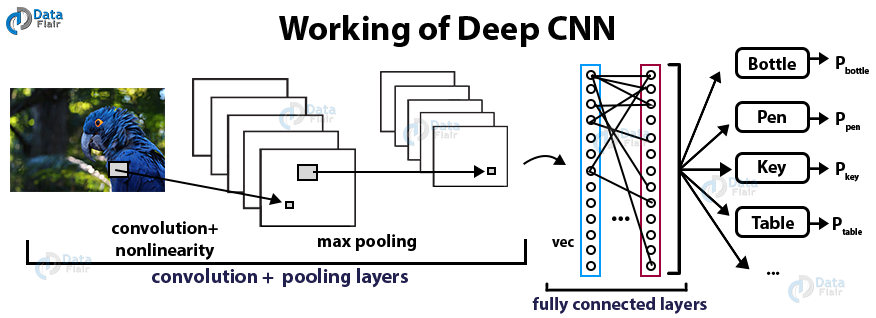
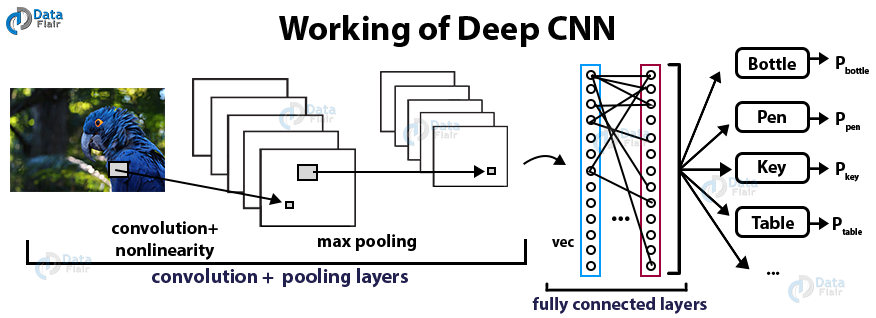
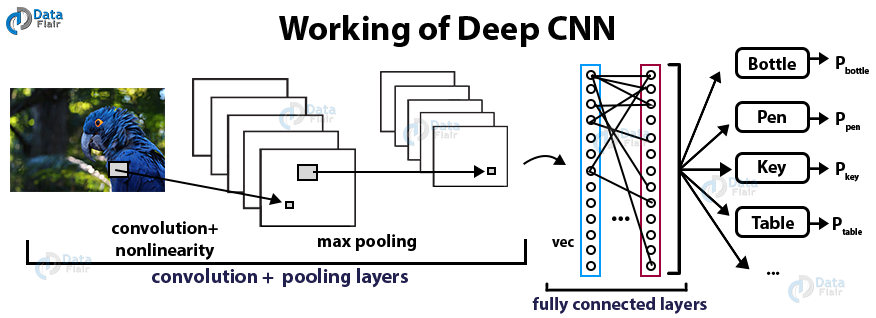

In [14]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
import os
from tqdm import tqdm
import pickle

image_path = '/kaggle/input/coco-image-caption/train2014/train2014'
output_path = '/kaggle/working/features_efficientnet.pkl'

# Load EfficientNetB3 model
base_model = EfficientNetB3(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Parameters
img_size = 300
batch_size = 32

# Get list of images
all_images = data['image'].unique().tolist()
features = {}

# Process in batches
for i in tqdm(range(0, len(all_images), batch_size), desc="Extracting features"):
    batch_images = all_images[i:i+batch_size]
    image_batch = []
    valid_filenames = []

    for image in batch_images:
        try:
            img_path = os.path.join(image_path, image)
            img = load_img(img_path, target_size=(img_size, img_size))
            img = img_to_array(img)
            img = preprocess_input(img)
            image_batch.append(img)
            valid_filenames.append(image)
        except:
            continue

    if image_batch:
        image_array = np.array(image_batch)
        feature_array = feature_extractor.predict(image_array, verbose=0)

        for j, fname in enumerate(valid_filenames):
            features[fname] = feature_array[j]

# Save features to file
with open(output_path, 'wb') as f:
    pickle.dump(features, f)

print(f"✅ Features saved to {output_path}")


I0000 00:00:1749889544.092034      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749889544.092757      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting features:   0%|          | 0/2587 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1749889554.682045     107 service.cc:148] XLA service 0x7fb920004a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749889554.682837     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749889554.682858     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749889555.855425     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749889565.408601     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Extracting features: 100%|██████████| 2587/2587 [33:40<00:00,  1.28it/s]


✅ Features saved to /kaggle/working/features_efficientnet.pkl


In [15]:
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

class CustomDataGenerator(Sequence):
    def __init__(self, df, image_col, caption_col, batch_size, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
        self.df = df.copy()
        self.image_col = image_col
        self.caption_col = caption_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features  # EfficientNet features (dict: image_id -> 1536-d np.array)
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch = self.df.iloc[batch_indexes]

        X_img, X_seq, y = self.__data_generation(batch)
        return (X_img, X_seq), y

    def __data_generation(self, batch):
        X_img, X_seq, y = [], [], []

        for _, row in batch.iterrows():
            image_id = row[self.image_col]
            caption = row[self.caption_col]

            # EfficientNet feature vector (1536-d)
            feature = self.features[image_id]

            seq = self.tokenizer.texts_to_sequences([caption])[0]

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq_padded = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq_onehot = to_categorical([out_seq], num_classes=self.vocab_size)[0]

                X_img.append(feature)
                X_seq.append(in_seq_padded)
                y.append(out_seq_onehot)

        return np.array(X_img), np.array(X_seq), np.array(y)


In [16]:
train_generator = CustomDataGenerator(
    df=train,
    image_col='image',
    caption_col='caption',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features,  # EfficientNet extracted features
    shuffle=True
)

val_generator = CustomDataGenerator(
    df=test,
    image_col='image',
    caption_col='caption',
    batch_size=64,
    tokenizer=tokenizer,
    vocab_size=vocab_size,
    max_length=max_length,
    features=features,  # EfficientNet extracted features
    shuffle=False
)


In [17]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Inputs
image_input = Input(shape=(1536,), name="image_input")  # EfficientNetB3 output
caption_input = Input(shape=(max_length,), name="caption_input")

# Image feature branch
img_dense = Dense(256, activation='relu')(image_input)
img_dense = Dropout(0.4)(img_dense)
img_reshaped = Reshape((1, 256))(img_dense)

# Caption branch
caption_embedding = Embedding(input_dim=vocab_size, output_dim=256)(caption_input)  # 👈 Removed mask_zero
caption_lstm = LSTM(256, return_sequences=True)(caption_embedding)
caption_lstm = Dropout(0.3)(caption_lstm)

# Merge
merged = Concatenate(axis=1)([img_reshaped, caption_lstm])
merged = LSTM(256)(merged)
merged = Dropout(0.5)(merged)

# Skip connection
skip = Concatenate()([merged, img_dense])
dense1 = Dense(256, activation='relu')(skip)
dropout1 = Dropout(0.5)(dense1)
output = Dense(vocab_size, activation='softmax')(dropout1)

# Model
caption_model = Model(inputs=[image_input, caption_input], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4))

caption_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 1536)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_input             │ (None, 51)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        393,472 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 51, 256)        │      6,248,448 │ caption_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 51, 256)        │        525,312 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 256)         │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 51, 256)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 52, 256)        │              0 │ reshape[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 256)            │        525,312 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 512)            │              0 │ dropout_2[0][0],       │
│ (Concatenate)             │                        │                │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 24408)          │      6,272,856 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 14,096,728 (53.77 MB)

 Trainable params: 14,096,728 (53.77 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "best_efficientnet_model.keras",   # <-- Renamed
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.2,
    min_lr=1e-8,
    verbose=1
)

history = caption_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[checkpoint, earlystopping, lr_scheduler]
)


Epoch 1/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - loss: 5.0191
Epoch 1: val_loss improved from inf to 3.69239, saving model to best_efficientnet_model.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1687s 306ms/step - loss: 5.0190 - val_loss: 3.6924 - learning_rate: 1.0000e-04
Epoch 2/10
5213/5500 ━━━━━━━━━━━━━━━━━━━━ 1:11 248ms/step - loss: 3.5582
Epoch 2: val_loss improved from 3.69239 to 3.42323, saving model to best_efficientnet_model.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1605s 292ms/step - loss: 3.5553 - val_loss: 3.4232 - learning_rate: 1.0000e-04
Epoch 3/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 3.3454
Epoch 3: val_loss improved from 3.42323 to 3.28532, saving model to best_efficientnet_model.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 1613s 293ms/step - loss: 3.3454 - val_loss: 3.2853 - learning_rate: 1.0000e-04
Epoch 4/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 3.2153
Epoch 4: val_loss improved from 3.28532 to 3.18520, saving model to best_efficientnet_model.ke

In [19]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)






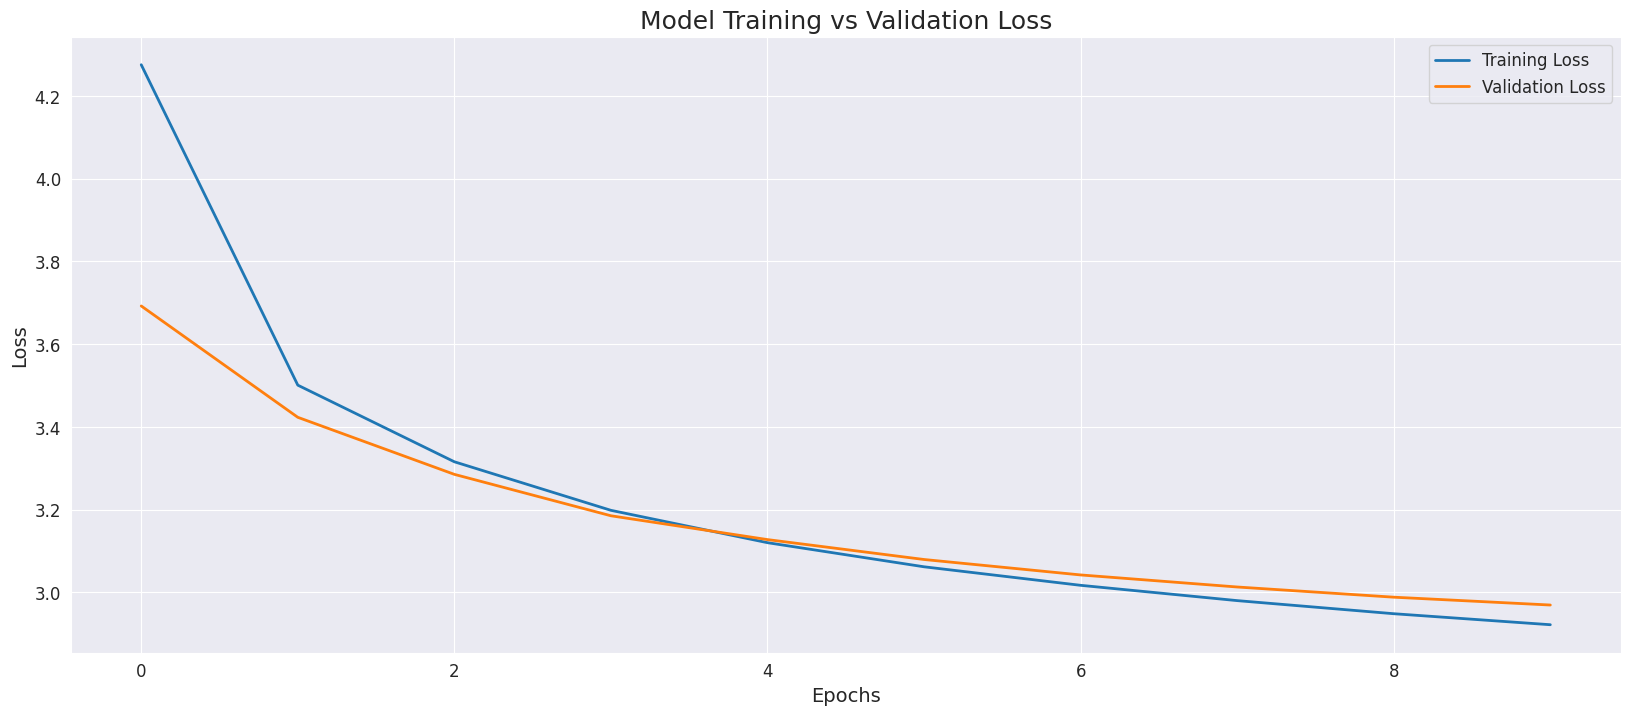

In [20]:
import matplotlib.pyplot as plt

def plot_training_loss(history):
    plt.figure(figsize=(20, 8))
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Training vs Validation Loss', fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)
    plt.show()

# Call the function with your history object
plot_training_loss(history)


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import os

def generate_caption_for_image(
    image_path,
    model_path="/kaggle/working/best_efficientnet_model.keras",
    tokenizer_path="/kaggle/working/tokenizer.pkl",
    feature_extractor_path="/kaggle/working/features_efficientnet.pkl",
    max_length=51,
    img_size=300
):
    # Load model
    caption_model = load_model(model_path)

    # Load tokenizer
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Load feature extractor (EfficientNet features)
    with open(feature_extractor_path, "rb") as f:
        features = pickle.load(f)

    # Extract image name from path
    image_filename = os.path.basename(image_path)

    # If image is already in feature dict (precomputed)
    if image_filename in features:
        image_feature = features[image_filename]
    else:
        # Preprocess new image and extract feature using EfficientNetB3
        from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
        base_model = EfficientNetB3(weights='imagenet', include_top=False, pooling='avg')
        feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)

        img = load_img(image_path, target_size=(img_size, img_size))
        img = img_to_array(img)
        img = preprocess_input(img)
        img = np.expand_dims(img, axis=0)

        image_feature = feature_extractor.predict(img, verbose=0)[0]

    # Start caption generation
    in_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([np.expand_dims(image_feature, axis=0), sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None or word == "endseq":
            break
        in_text += " " + word

    caption = in_text.replace("startseq", "").strip().capitalize()

    # Show image with caption
    img_to_show = load_img(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_to_show)
    plt.axis("off")
    plt.title(caption, fontsize=16, color='darkblue')
    plt.show()

    return caption


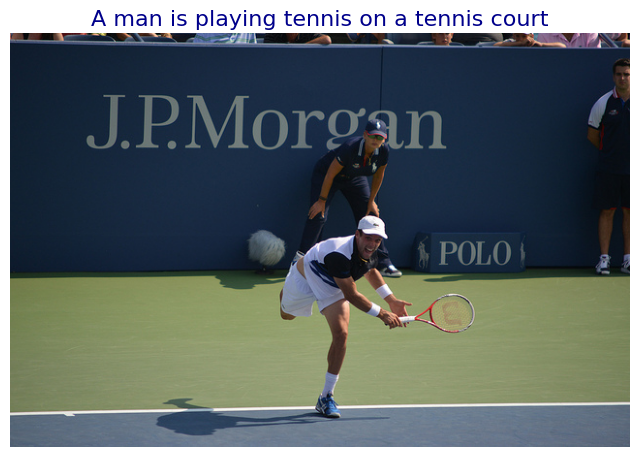

'A man is playing tennis on a tennis court'

In [28]:
generate_caption_for_image(
    "/kaggle/input/coco-image-caption/val2017/val2017/000000000885.jpg"
    
)
